In [8]:
import sys
import os
import collections
from collections import defaultdict
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import re
from tabula import read_pdf
import csv

import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from imblearn.over_sampling import SMOTE

import requests
from bs4 import BeautifulSoup

import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (15, 8)  # Width=15, Height=8


In [82]:
print("Opening BAC2019 csv...")
data_bac = pd.read_csv("./BAC CSV/bac2019.csv", skip_blank_lines=True)
data_bac.head(10)

Opening BAC2019 csv...


,Cod unic candidat,Sex,Specializare,Profil,Filiera,Forma de învățământ,Mediu candidat,Subiect ea,Subiect eb,Limba modernă,...,SCRIS_PMS,ORAL_PMO,ORAL_IO,PUNCTAJ DIGITALE,STATUS,Medie,NOTA_FINALA_EA,NOTA_FINALA_EB,NOTA_FINALA_EC,NOTA_FINALA_ED
0,10530,M,Filologie,Uman,Teoretică,Zi,URBAN,Limba română (UMAN),NaN,Limba engleză,...,A2,B2,B2,22.0,Promovat,6.01,5.00,NaN,5.25,7.80
1,11067,F,Științe Sociale,Uman,Teoretică,Frecvență redusă,URBAN,Limba română (UMAN),NaN,Limba engleză,...,B1,B2,B2,44.0,Nepromovat,5.38,5.90,NaN,5.25,5.00
2,11185,M,Științe ale Naturii,Real,Teoretică,Zi,URBAN,Limba română (REAL),NaN,Limba engleză,...,-,B1,B1,NaN,Nepromovat,NaN,3.60,NaN,7.00,5.10
3,12449,M,Matematica-Informatica,Real,Teoretică,Zi,URBAN,Limba română (REAL),NaN,Limba engleză,...,A1,A2,A2,76.0,Promovat,7.00,8.60,NaN,6.95,5.45
4,12341,F,Științe Sociale,Uman,Teoretică,Frecvență redusă,URBAN,Limba română (UMAN),NaN,Limba engleză,...,A1,A2,A2,28.0,Nepromovat,NaN,3.25,NaN,5.40,6.20
5,12195,M,Tehnician în turism,Servicii,Tehnologică,Frecvență redusă,URBAN,Limba română (REAL),NaN,Limba engleză,...,-,A2,A2,20.0,Absent,NaN,-2.00,NaN,-2.00,-2.00
6,12614,F,Matematica-Informatica,Real,Teoretică,Zi,RURAL,Limba română (REAL),NaN,Limba engleză,...,A2,A2,A2,35.0,Promovat,6.66,5.95,NaN,5.05,9.00
7,12615,F,Matematica-Informatica,Real,Teoretică,Zi,RURAL,Limba română (REAL),NaN,Limba franceză,...,A2,B2,B2,53.0,Nepromovat,NaN,6.55,NaN,2.45,5.60
8,13733,M,Tehnician electrician/electronist auto,Tehnic,Tehnologică,Zi,RURAL,Limba română (REAL),NaN,Limba franceză,...,-,B2,B2,NaN,Nepromovat,NaN,5.40,NaN,1.20,6.00
9,13522,M,Matematica-Informatica,Real,Teoretică,Zi,RURAL,Limba română (REAL),NaN,Limba engleză,...,A2,A2,A2,65.0,Promovat,6.93,7.50,NaN,5.00,8.30


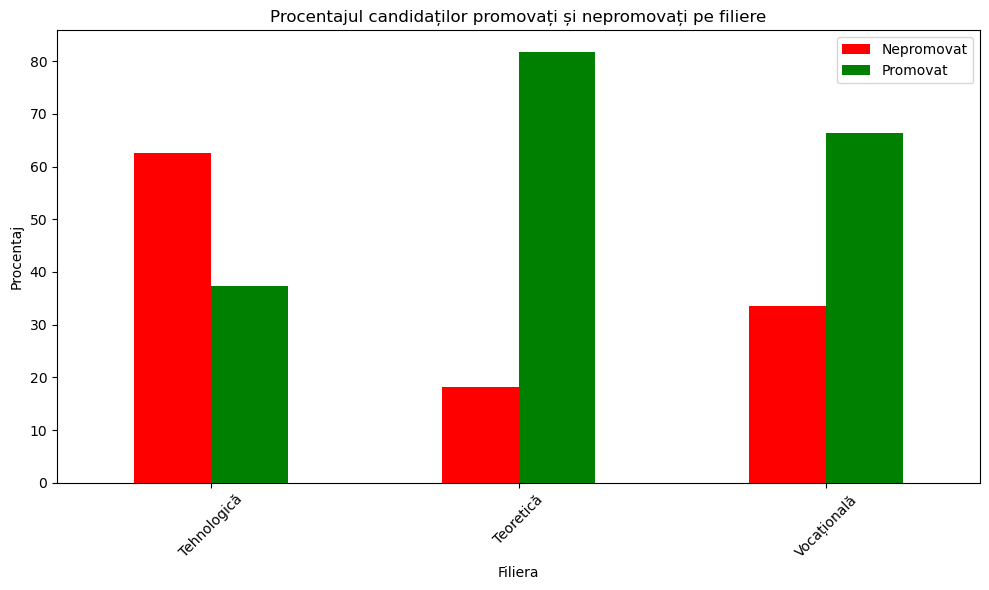

In [83]:
data_bac['Promovat'] = data_bac['STATUS'].apply(lambda x: 1 if str(x).lower() == 'promovat' else 0)

filiera_status = data_bac.groupby('Filiera')['Promovat'].value_counts(normalize=True).unstack() * 100

filiera_status.plot(kind='bar', stacked=False, color=['red', 'green'], figsize=(10, 6))

plt.title('Procentajul candidaților promovați și nepromovați pe filiere')
plt.xlabel('Filiera')
plt.ylabel('Procentaj')
plt.xticks(rotation=45)
plt.legend(['Nepromovat', 'Promovat'], loc='upper right')
plt.tight_layout()

plt.show()

In [5]:
# Load the Bacalaureate results dataset
bac_results = pd.read_csv("./BAC CSV/bac2019.csv")

# Data Preprocessing
bac_results_clean = bac_results.copy()
bac_results_clean = bac_results_clean.dropna(subset=['Medie'])
bac_results_clean['Medie'] = bac_results_clean['Medie'].astype(float)

# Convert all categorical columns to numeric
label_encoder = LabelEncoder()
categorical_cols = bac_results_clean.select_dtypes(include='object').columns
for col in categorical_cols:
    bac_results_clean[col] = label_encoder.fit_transform(bac_results_clean[col].astype(str))

# Handle any negative or invalid scores
for col in bac_results_clean.columns:
    if 'NOTA_FINALA' in col or col == 'Medie':
        bac_results_clean[col] = bac_results_clean[col].apply(lambda x: np.nan if x < 0 else x)

# Fill remaining NaN values with the mean of each column
bac_results_clean.fillna(bac_results_clean.mean(), inplace=True)

# Features and target for classification
X_class = bac_results_clean.drop(columns=['STATUS', 'Medie', 'Cod unic candidat'])
y_class = bac_results_clean['STATUS']

# Scale features
scaler = StandardScaler()
X_class_scaled = scaler.fit_transform(X_class)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_class_scaled, y_class, test_size=0.3, random_state=42)


Cross-Validation Accuracy Scores (Random Forest): [0.92164239 0.92316004 0.95513667 0.96894385 0.96682275]
Mean Cross-Validation Accuracy (Random Forest): 0.95

Classification Report (Random Forest):
              precision    recall  f1-score   support

  Nepromovat     0.9203    0.8479    0.8826     11978
    Promovat     0.9342    0.9671    0.9504     26748

    accuracy                         0.9302     38726
   macro avg     0.9272    0.9075    0.9165     38726
weighted avg     0.9299    0.9302    0.9294     38726


Confusion Matrix (Random Forest):
                    Predicted Nepromovat  Predicted Promovat
Actual Nepromovat                 10156                1822
Actual Promovat                     880               25868


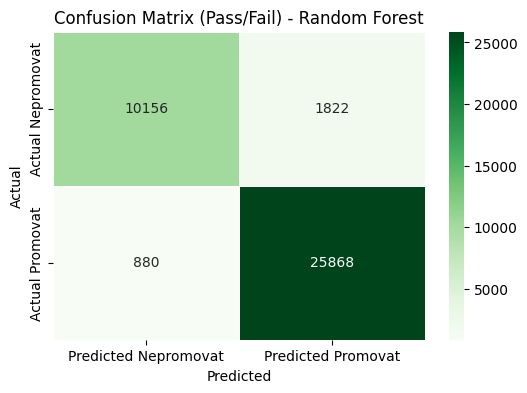

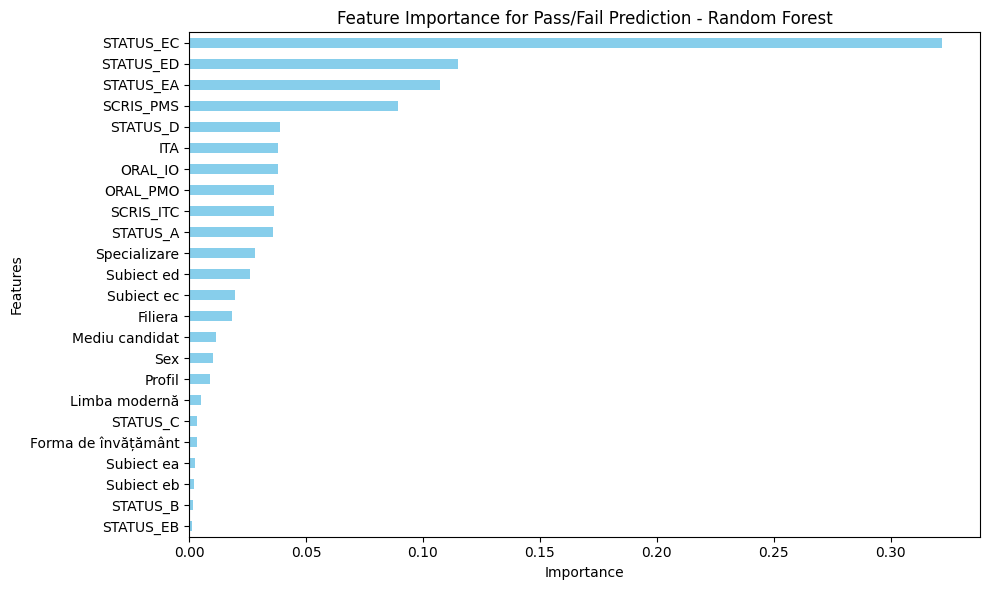

In [6]:
# 1. Random Forest Classifier
# Purpose: Improves pass/fail prediction using an ensemble of decision trees.
# Type: Classification
# Output: More robust and accurate pass/fail prediction than Logistic Regression.
from imblearn.over_sampling import SMOTE
# Load data
data_bac = pd.read_csv("./BAC CSV/bac2019.csv")

# Filter to keep only 'Promovat' and 'Nepromovat'
data_bac = data_bac[data_bac['STATUS'].isin(['Promovat', 'Nepromovat'])]

# Encode categorical features (except target)
label_encoder = LabelEncoder()
for col in data_bac.select_dtypes(include='object').columns:
    if col != 'STATUS':
        data_bac[col] = label_encoder.fit_transform(data_bac[col].astype(str))

# Encode target: Promovat (1), Nepromovat (0)
data_bac['STATUS'] = data_bac['STATUS'].apply(lambda x: 1 if x == 'Promovat' else 0)

# Drop grade-related columns to prevent the model from using them
grade_columns = [col for col in data_bac.columns if 'NOTA_FINALA' in col or col in ['Medie', 'PUNCTAJ DIGITALE']]
X = data_bac.drop(columns=['STATUS', 'Cod unic candidat'] + grade_columns)
y = data_bac['STATUS']

# Drop columns with NaN values (for SMOTE)
X_no_nan = X.dropna(axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_no_nan, y, test_size=0.3, random_state=42)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scale features after SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Random Forest Classifier with balanced class weight
clf_rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)

# Cross-validation
cv_scores_rf = cross_val_score(clf_rf, X_train_scaled, y_train_smote, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy Scores (Random Forest): {cv_scores_rf}")
print(f"Mean Cross-Validation Accuracy (Random Forest): {cv_scores_rf.mean():.2f}")

# Train the model
clf_rf.fit(X_train_scaled, y_train_smote)

# Predictions
y_pred_rf = clf_rf.predict(X_test_scaled)
y_pred_proba_rf = clf_rf.predict_proba(X_test_scaled)

# Classification Report (Promovat vs. Nepromovat)
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=['Nepromovat', 'Promovat'], digits=4))

# Compute the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Confusion matrix DataFrame
conf_matrix_df_rf = pd.DataFrame(conf_matrix_rf, index=['Actual Nepromovat', 'Actual Promovat'],
                                 columns=['Predicted Nepromovat', 'Predicted Promovat'])
print("\nConfusion Matrix (Random Forest):\n", conf_matrix_df_rf)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df_rf, annot=True, fmt='d', cmap='Greens', linewidths=0.5)
plt.title('Confusion Matrix (Pass/Fail) - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance Plot
feature_importances = pd.Series(clf_rf.feature_importances_, index=X_no_nan.columns)
plt.figure(figsize=(10, 6))
feature_importances.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Importance for Pass/Fail Prediction - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


Cross-Validation Accuracy Scores (Random Forest): [0.73967504 0.73866411 0.74166567 0.74790891 0.74102533]
Mean Cross-Validation Accuracy (Random Forest): 0.74

Classification Report (Random Forest):
              precision    recall  f1-score   support

  Nepromovat     0.5833    0.6946    0.6341     11978
    Promovat     0.8505    0.7778    0.8125     26748

    accuracy                         0.7521     38726
   macro avg     0.7169    0.7362    0.7233     38726
weighted avg     0.7678    0.7521    0.7573     38726


Confusion Matrix (Random Forest):
                    Predicted Nepromovat  Predicted Promovat
Actual Nepromovat                  8320                3658
Actual Promovat                    5943               20805


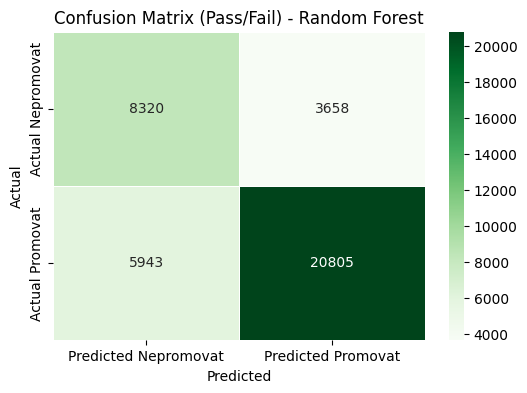

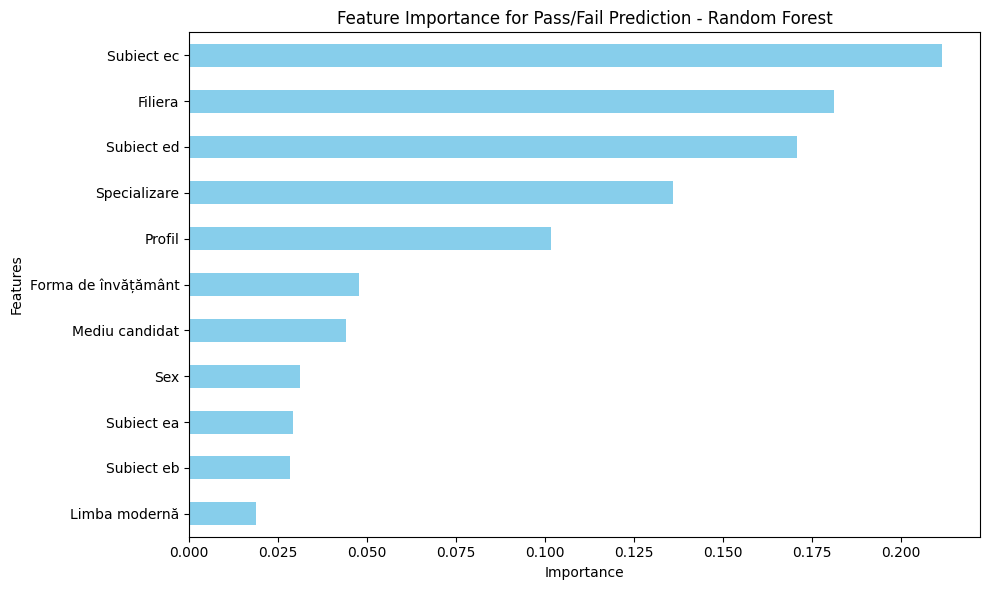

In [7]:
# 2. Random Forest Classifier - More restrictive analysis - Harder predictability

# Load data
data_bac = pd.read_csv("./BAC CSV/bac2019.csv")

# Filter to keep only 'Promovat' and 'Nepromovat'
data_bac = data_bac[data_bac['STATUS'].isin(['Promovat', 'Nepromovat'])]

# Encode categorical features (except target)
label_encoder = LabelEncoder()
for col in data_bac.select_dtypes(include='object').columns:
    if col != 'STATUS':
        data_bac[col] = label_encoder.fit_transform(data_bac[col].astype(str))

# Encode target: Promovat (1), Nepromovat (0)
data_bac['STATUS'] = data_bac['STATUS'].apply(lambda x: 1 if x == 'Promovat' else 0)

# Drop grade-related and status-related columns to prevent the model from using them
grade_columns = [col for col in data_bac.columns if 'NOTA_FINALA' in col or col in ['Medie', 'PUNCTAJ DIGITALE']]
status_columns = ['STATUS_A', 'STATUS_B', 'STATUS_C', 'STATUS_D', 'STATUS_EA', 'STATUS_EB', 'STATUS_EC', 'STATUS_ED']
extra_columns = ['SCRIS_PMS', 'SCRIS_ITC', 'ORAL_PMO', 'ORAL_IO', 'ITA']
X = data_bac.drop(columns=['STATUS', 'Cod unic candidat'] + grade_columns + status_columns + extra_columns)
y = data_bac['STATUS']

# Drop columns with NaN values (for SMOTE)
X_no_nan = X.dropna(axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_no_nan, y, test_size=0.3, random_state=42)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scale features after SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Random Forest Classifier with balanced class weight
clf_rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)

# Cross-validation
cv_scores_rf = cross_val_score(clf_rf, X_train_scaled, y_train_smote, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy Scores (Random Forest): {cv_scores_rf}")
print(f"Mean Cross-Validation Accuracy (Random Forest): {cv_scores_rf.mean():.2f}")

# Train the model
clf_rf.fit(X_train_scaled, y_train_smote)

# Predictions
y_pred_rf = clf_rf.predict(X_test_scaled)
y_pred_proba_rf = clf_rf.predict_proba(X_test_scaled)

# Classification Report (Promovat vs. Nepromovat)
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=['Nepromovat', 'Promovat'], digits=4))

# Compute the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Confusion matrix DataFrame
conf_matrix_df_rf = pd.DataFrame(conf_matrix_rf, index=['Actual Nepromovat', 'Actual Promovat'],
                                 columns=['Predicted Nepromovat', 'Predicted Promovat'])
print("\nConfusion Matrix (Random Forest):\n", conf_matrix_df_rf)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df_rf, annot=True, fmt='d', cmap='Greens', linewidths=0.5)
plt.title('Confusion Matrix (Pass/Fail) - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance Plot
feature_importances = pd.Series(clf_rf.feature_importances_, index=X_no_nan.columns)
plt.figure(figsize=(10, 6))
feature_importances.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Importance for Pass/Fail Prediction - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


 Performing K-Means Clustering...


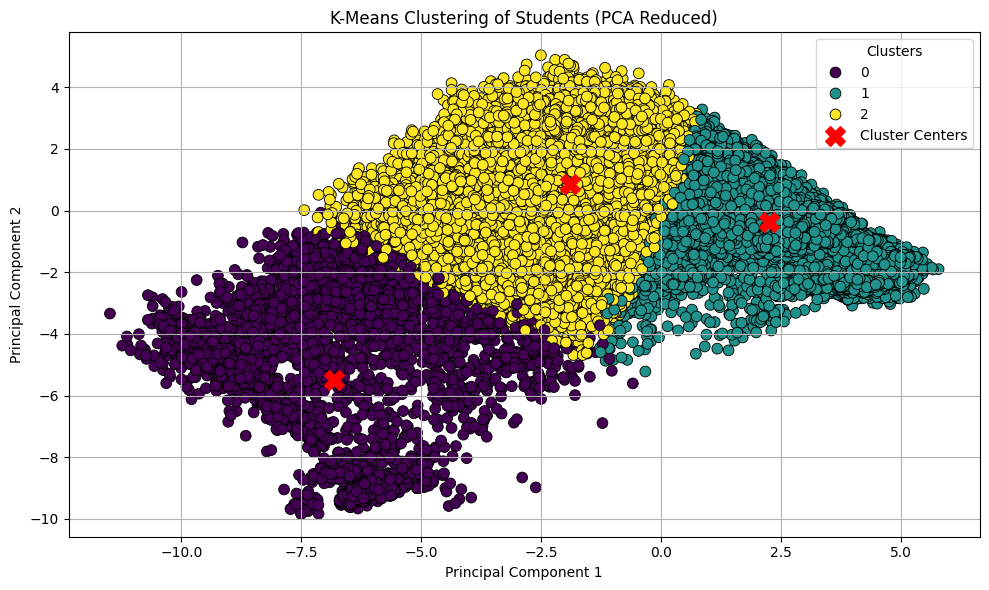


Cluster Summary:
  Cluster 0: 5169 students (3.80% of total)
  Cluster 1: 68526 students (50.35% of total)
  Cluster 2: 62396 students (45.85% of total)

Top Specializations in Each Cluster:

 Cluster 0:
     - Tehnician mecanic pentru întreținere și reparații: 390 students
     - Științe ale Naturii: 362 students
     - Filologie: 288 students

 Cluster 1:
     - Matematica-Informatica: 20245 students
     - Filologie: 15064 students
     - Științe ale Naturii: 12344 students

 Cluster 2:
     - Științe ale Naturii: 7200 students
     - Tehnician în activități economice: 6328 students
     - Filologie: 6149 students

 Detailed Cluster Comparison:

 Sex by Cluster:
 Cluster 0: Mean = 0.59, Std = 0.49
 Cluster 1: Mean = 0.43, Std = 0.50
 Cluster 2: Mean = 0.50, Std = 0.50

 Profil by Cluster:
 Cluster 0: Mean = 6.05, Std = 1.81
 Cluster 1: Mean = 5.70, Std = 2.61
 Cluster 2: Mean = 5.84, Std = 2.15

 Filiera by Cluster:
 Cluster 0: Mean = 0.33, Std = 0.58
 Cluster 1: Mean = 1.00, Std =

In [9]:
# 3. K-Means Clustering
# Purpose: Groups students into clusters based on similarities in their data (e.g., performance, specialization).
# Type: Unsupervised Learning (Clustering)
# Output: Clusters of students visualized in a scatter plot.


# Load the data
df = pd.read_csv("./BAC CSV/bac2019.csv")

# Handle missing data by filling with mode for categorical and mean for numerical columns
for col in df.columns:
    if df[col].dtype == 'object':  # Exclude 'Specializare' from encoding
        df[col].fillna(df[col].mode()[0], inplace=True)
    elif df[col].dtype != 'object':
        df[col].fillna(df[col].mean(), inplace=True)

# Encode categorical variables except 'Specializare'
label_encoder = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    if col != 'Specializare':
        df[col] = label_encoder.fit_transform(df[col].astype(str))

# Prepare data for clustering (dropping non-relevant columns)
X_class = df.drop(columns=['Cod unic candidat', 'Specializare'])

# Data Preparation and Scaling
print("\n Performing K-Means Clustering...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_class)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Assign cluster labels
df['Cluster'] = kmeans.labels_

# Dimensionality Reduction for Visualization (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Plot Clusters in 2D Space
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis', s=60, edgecolor='black')

# Plot cluster centers
centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label='Cluster Centers')

plt.title('K-Means Clustering of Students (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Clusters')
plt.grid(True)
plt.tight_layout()
plt.show()

# Cluster Summary
print("\nCluster Summary:")
total_students = len(df)
for cluster_num in sorted(df['Cluster'].unique()):
    cluster_size = (df['Cluster'] == cluster_num).sum()
    percentage = (cluster_size / total_students) * 100
    print(f"  Cluster {cluster_num}: {cluster_size} students ({percentage:.2f}% of total)")

# Cluster Insights
print("\nTop Specializations in Each Cluster:")
for cluster_num in sorted(df['Cluster'].unique()):
    specializations = df[df['Cluster'] == cluster_num]['Specializare'].value_counts().head(3)
    print(f"\n Cluster {cluster_num}:")
    for spec_name, count in specializations.items():
        print(f"     - {spec_name}: {count} students")

# Detailed Cluster Comparison
print("\n Detailed Cluster Comparison:")
numeric_features = X_class.columns
for feature in numeric_features:
    print(f"\n {feature} by Cluster:")
    feature_means = df.groupby('Cluster')[feature].mean()
    feature_stds = df.groupby('Cluster')[feature].std()
    for cluster_num in sorted(df['Cluster'].unique()):
        print(f" Cluster {cluster_num}: Mean = {feature_means[cluster_num]:.2f}, Std = {feature_stds[cluster_num]:.2f}")



Loading and cleaning Bacalaureate data...

Scaling data for PCA...

Applying PCA for visualization...

📖 Explanation:
 - PCA reduces high-dimensional data to 2 dimensions for visualization.
 - Each point represents a student, colored by their specialization.
 - The separation between groups indicates how similar or different students are based on their data.


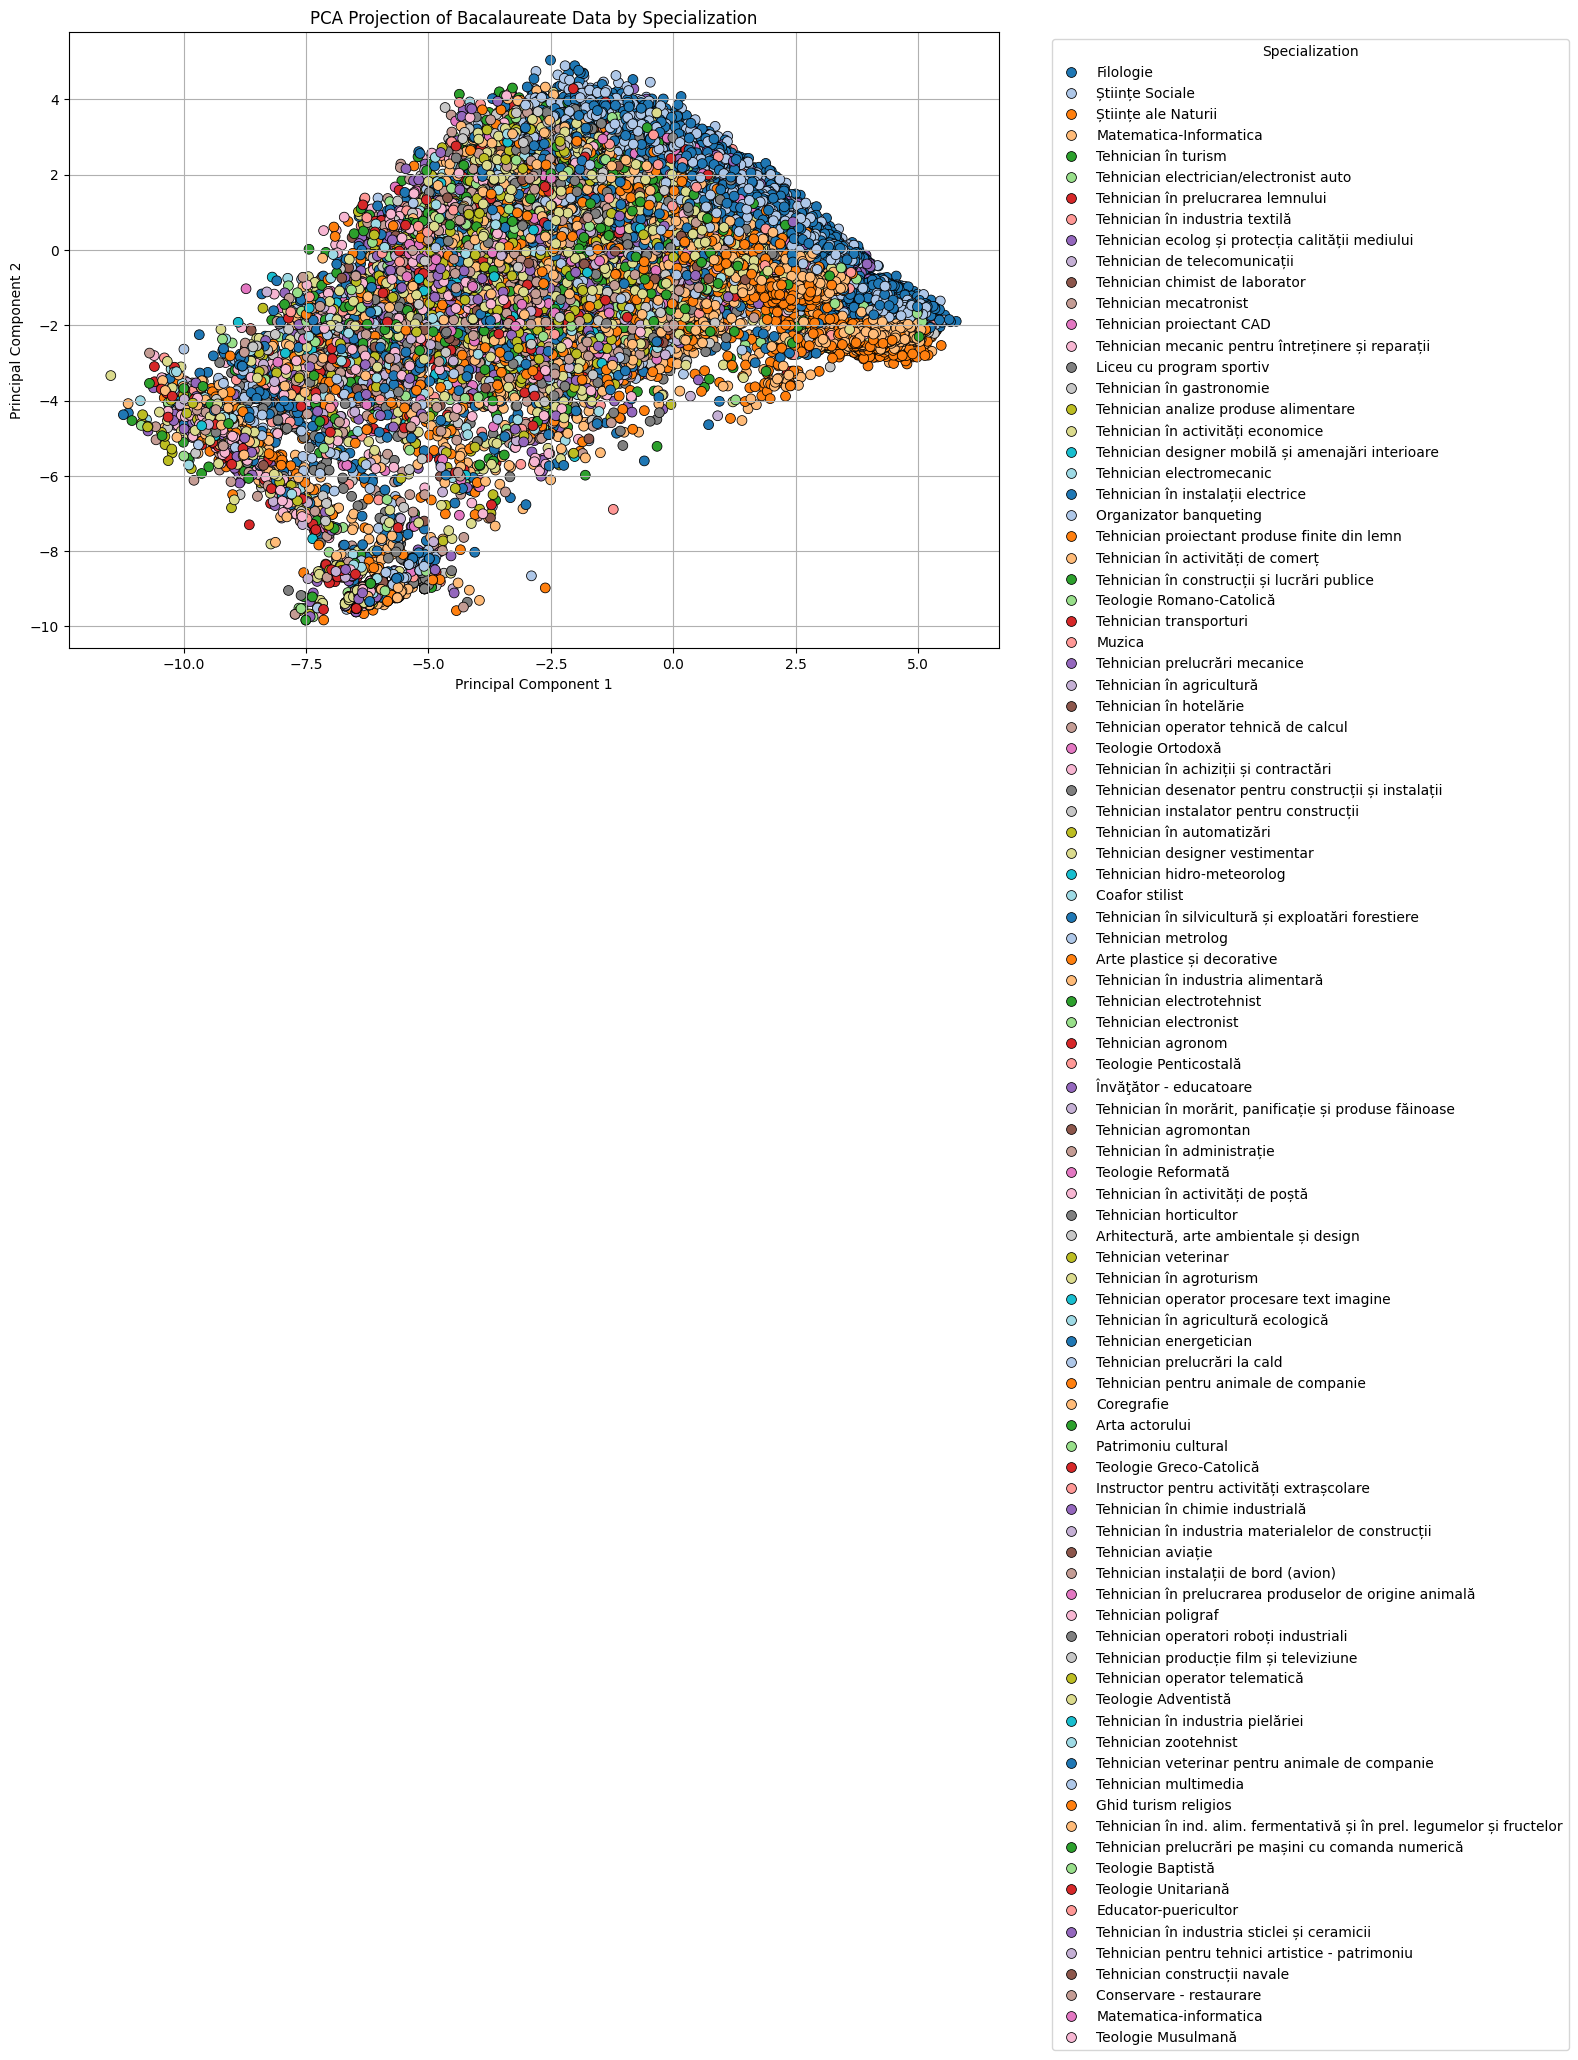

In [11]:
# 4. PCA for Visualization
# Purpose: Reduces data dimensions to 2D for easier visualization of student distribution.
# Type: Dimensionality Reduction
# Output: 2D scatter plot showing student distribution and cluster separation.

#  Load and Clean the Data
print("\nLoading and cleaning Bacalaureate data...")
df = pd.read_csv("./BAC CSV/bac2019.csv")

# Fill missing values: mode for categorical, mean for numerical
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    elif df[col].dtype != 'object':
        df[col].fillna(df[col].mean(), inplace=True)

# Encode categorical variables except 'Specializare'
label_encoder = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    if col != 'Specializare':
        df[col] = label_encoder.fit_transform(df[col].astype(str))

# Prepare data by dropping irrelevant columns
X_class = df.drop(columns=['Cod unic candidat', 'Specializare'])

# Data Scaling
print("\nScaling data for PCA...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_class)

# Apply PCA for Visualization
print("\nApplying PCA for visualization...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Explanation of PCA Plot
print("\n📖 Explanation:")
print(" - PCA reduces high-dimensional data to 2 dimensions for visualization.")
print(" - Each point represents a student, colored by their specialization.")
print(" - The separation between groups indicates how similar or different students are based on their data.")

# Intuitive PCA Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Specializare', palette='tab20', s=50, edgecolor='black')
plt.title('PCA Projection of Bacalaureate Data by Specialization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Specialization', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



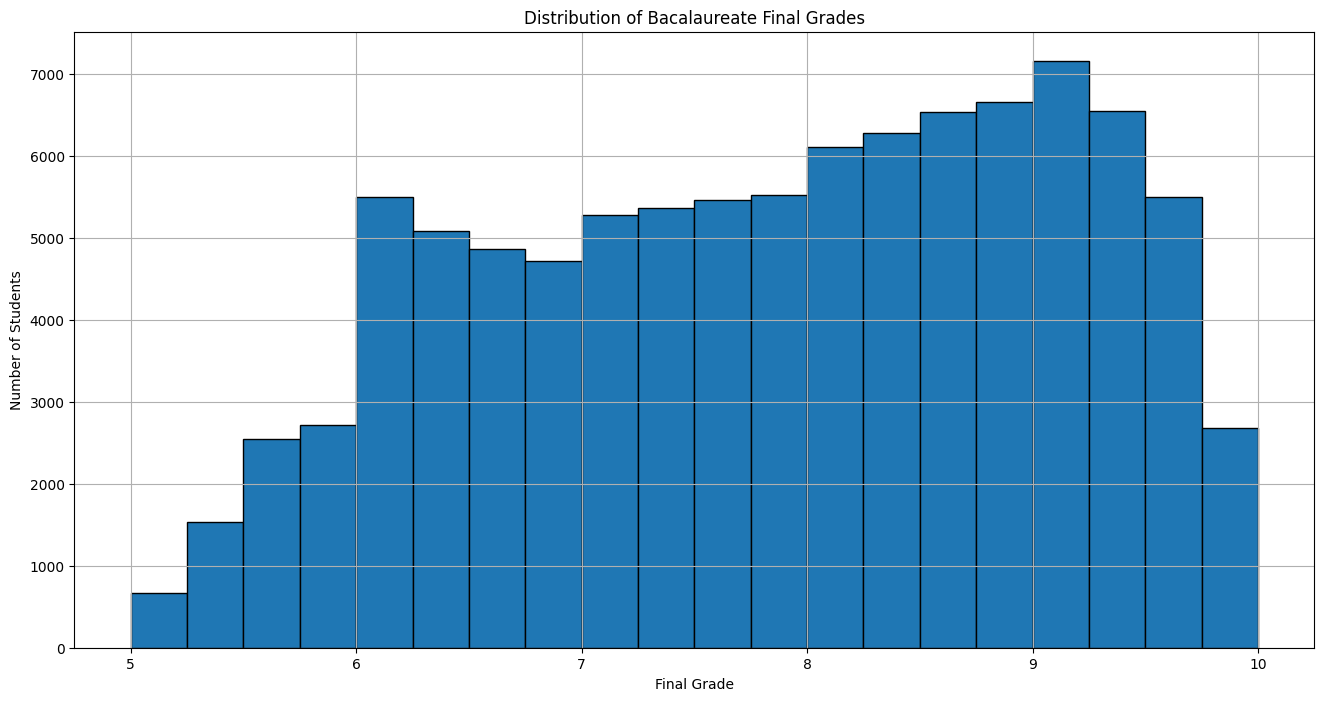

In [16]:
# Graphs & Charts
bac_results_clean = pd.read_csv("./BAC CSV/bac2019.csv")

# 1. Histogram of Bacalaureate Final Grades
plt.rcParams['figure.figsize'] = (16, 8)
plt.figure()
bac_results_clean['Medie'].hist(bins=20, edgecolor='black')
plt.xlabel('Final Grade')
plt.ylabel('Number of Students')
plt.title('Distribution of Bacalaureate Final Grades')
plt.show()

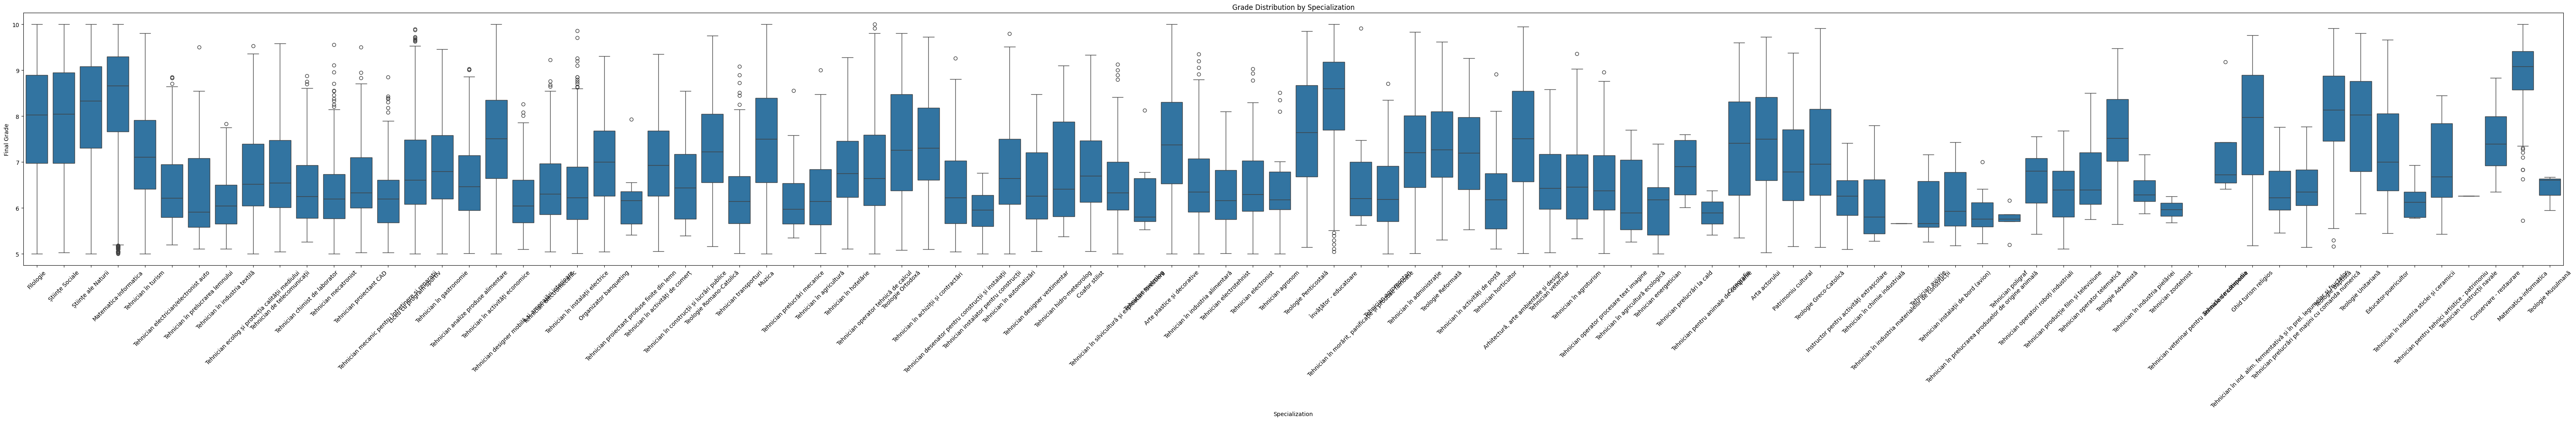

In [17]:
# 2. Boxplot of Grades by Specialization
plt.rcParams['figure.figsize'] = (80, 8)
plt.figure()
sns.boxplot(x='Specializare', y='Medie', data=bac_results_clean)
plt.xlabel('Specialization')
plt.ylabel('Final Grade')
plt.title('Grade Distribution by Specialization')
plt.xticks(rotation=45)
plt.show()

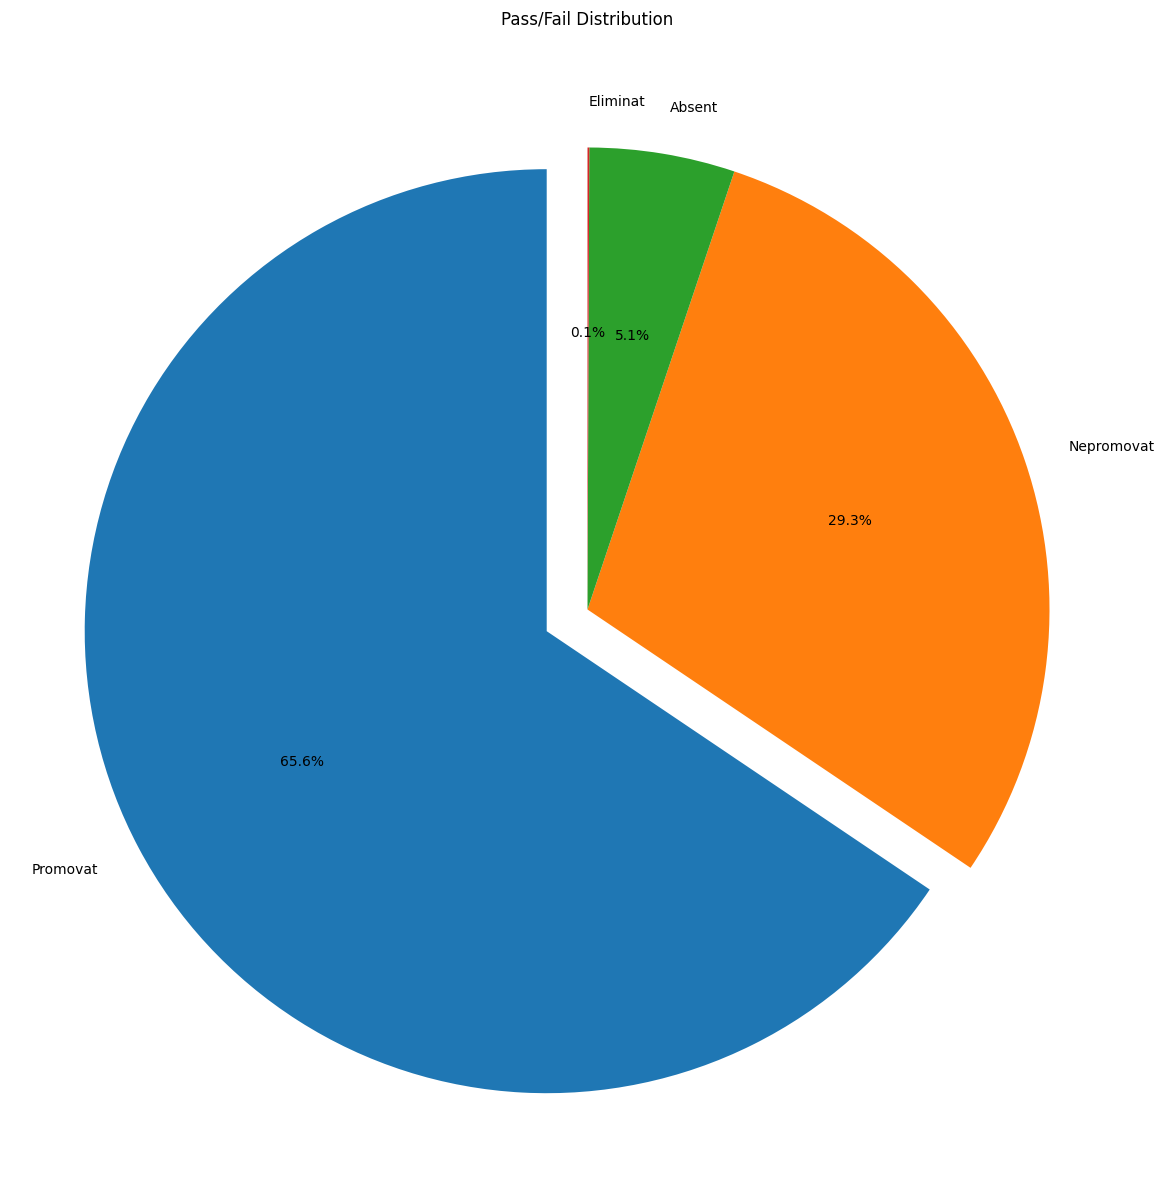

In [21]:
# 3. Pass/Fail Rate
plt.rcParams['figure.figsize'] = (20, 15)
plt.figure()
status_counts = bac_results_clean['STATUS'].value_counts()
# Dynamically set explode to match the number of categories
explode = [0.1] + [0] * (len(status_counts) - 1)
status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, explode=explode)
plt.ylabel('')
plt.title('Pass/Fail Distribution')
plt.show()

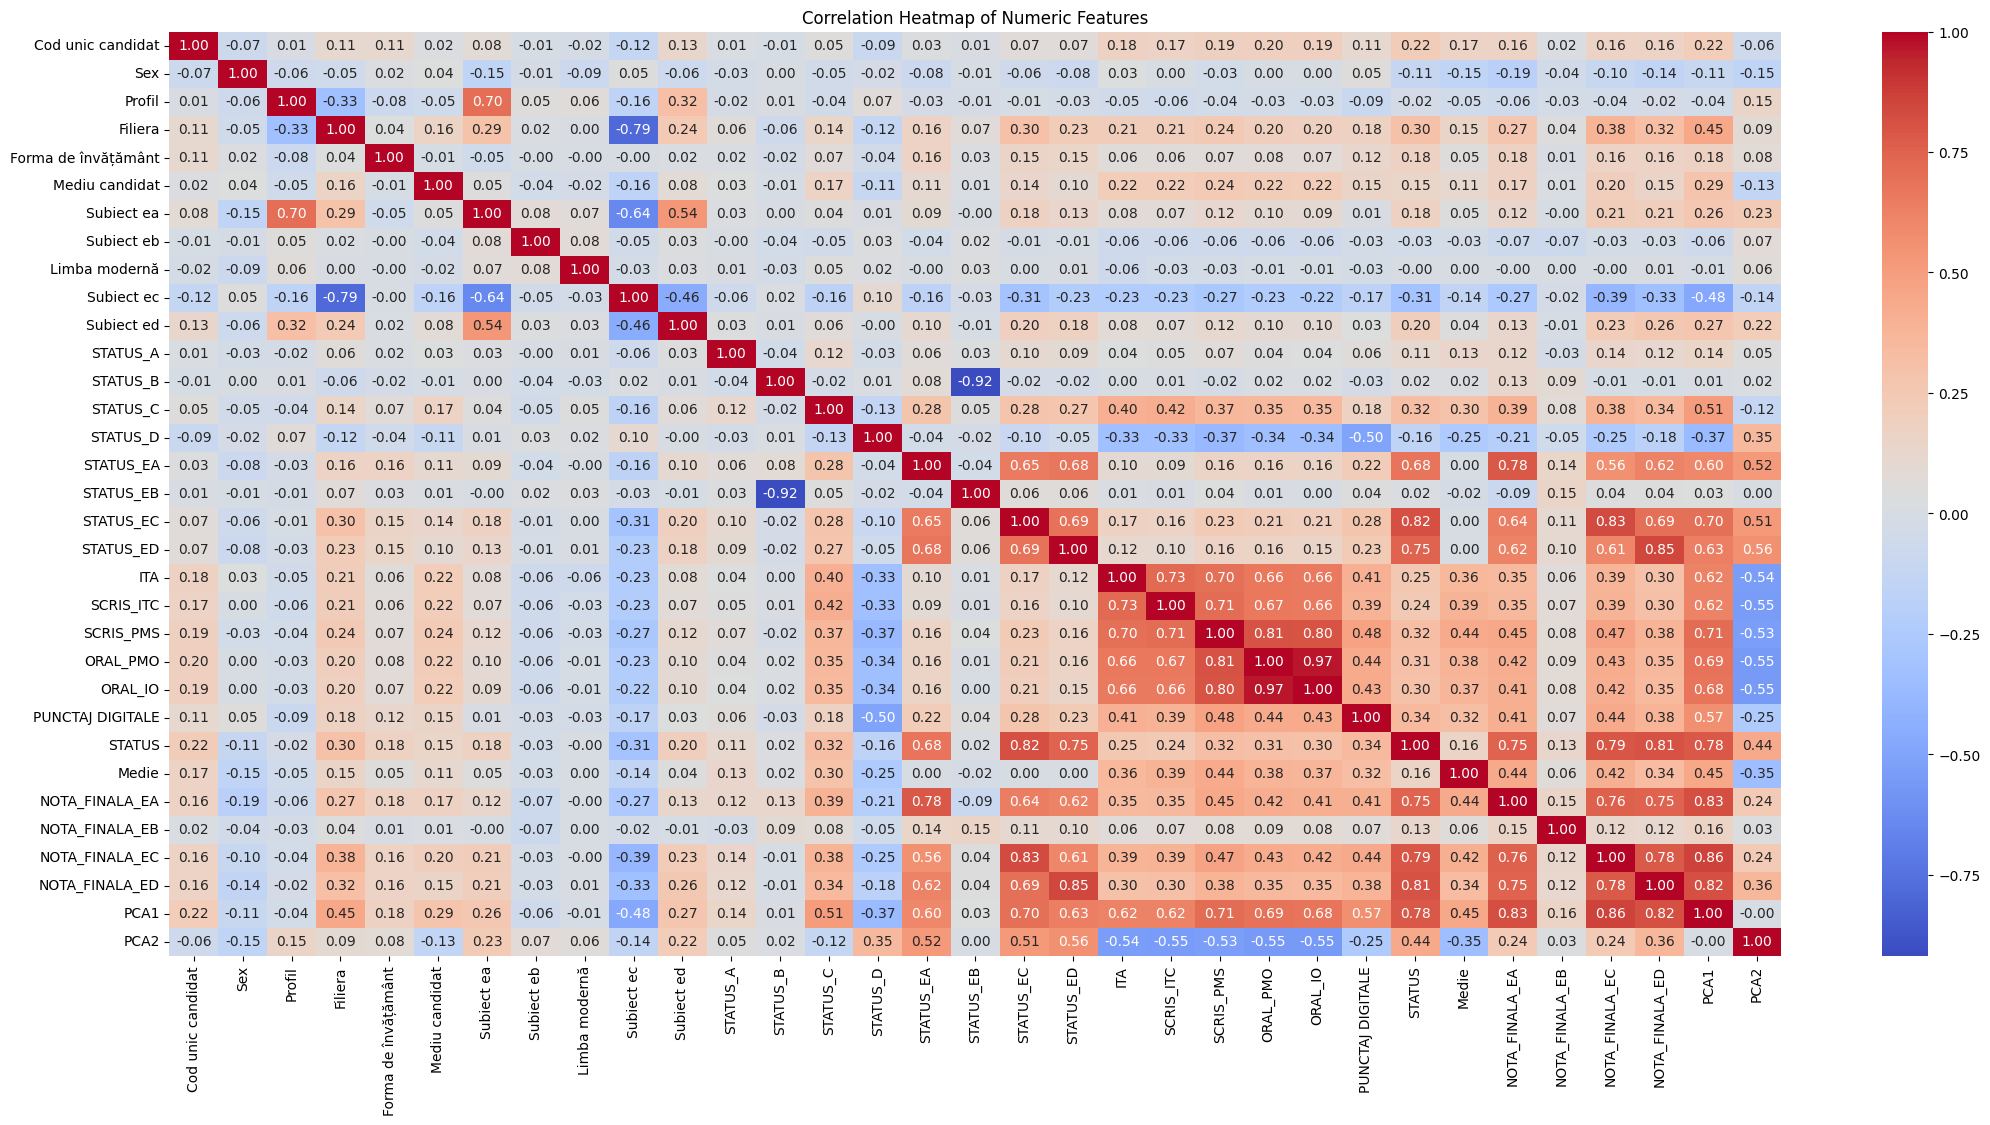

In [19]:
# 4. Correlation Heatmap of Numeric Features Only
# Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into fewer dimensions while preserving as much variance (information) as possible.

# PCA1 (Principal Component 1):
#    Captures the maximum variance in the data.
#    Represents the most significant feature combination in the dataset.
#    Explains the most important differences between students in the dataset.

# PCA2 (Principal Component 2):
#    Captures the second-highest variance, orthogonal to PCA1.
#    It explains additional variance that PCA1 doesn't capture.
plt.figure(figsize=(26, 12))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()